<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>

# Practicum Project: Bincentive

## Pairtrading: Version 0404 ##

* Yu-Ching Liao <ycliao3@illinois.edu>

# Only Using Crypto

## Basic Import

In [1]:
import os
import ccxt
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import warnings 
warnings.filterwarnings('ignore')
import itertools

## Basic Defination 

In [2]:
def Delete_all_CSV(i):
    pngfiles = [f for f in os.listdir(i) if f.endswith(".csv")]
    print("existing png files: " + str(pngfiles))
    [os.remove(i + f) for f in pngfiles]
    print("All csv removed.")
    print("------------------------------------------------------")


def saver(fname):
    plt.savefig(fname + ".png", bbox_inches="tight")


def generate_result(model, y, y_pred, timestamp):
    #Kill Previous Result

    # First Generate Plot
    r2 = R2(y, y_pred)
    mse = MSE(y, y_pred)
    mape = MAPE(y, y_pred)

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(timestamp, y, color='navy', label="BTC/USDT")
    ax.plot(timestamp, y_pred, color="orange", label='fitted value')

    ax.set_title(model)
    ax.set_ylabel("Normalized Prices")
    ax.set_xlabel("Date")

    table_data = [["R2", r2], ["MSE", mse], ["MAPE", mape]]
    table = ax.table(cellText=table_data,
                     cellLoc="center",
                     colWidths=[0.5, 1.5],
                     colLabels=['Index', 'Result'],
                     loc="center",
                     bbox=[0, -0.5, 1, 0.3])
    table.set_fontsize(10)

    # Place the legend outside the plot to the right
    ax.legend()

    #saver('/Users/yu-chingliao/Desktop/untitled folder/'+symbol_1.replace("/", "_")+" vs "+symbol_2.replace("/", "_"))
    #plt.close()
    plt.show()
    print("Task Complete. ")


## Fetching Data

In [3]:


# Initialize the Coinbase Pro exchange object
exchange = ccxt.coinbasepro({
    'rateLimit': 1000,
    'enableRateLimit': True,
})

# Function to fetch historical data
def fetch_historical_data(exchange, symbol, timeframe, since, until):
    data = []
    while since < until:
        chunk = exchange.fetch_ohlcv(symbol, timeframe, since)
        if not chunk:
            break
        since = chunk[-1][0] + 1  # Move to the next timestamp
        data += chunk
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['rate_of_return'] = df['close'].pct_change()
    return df

Delete_all_CSV('/Users/yu-chingliao/Desktop/Bincentive Practicum/model 1/')

correlated_pairs = [
    'BTC/USDT',
    'ETH/USDT',
    'ADA/USDT',
    'DOGE/USDT',
    'SOL/USDT',
    'DOT/USDT',
    'LINK/USDT',
    'XLM/USDT',
    'EOS/USDT',
    'XMR/USDT',
    'TRX/USDT'
]



since = exchange.parse8601('2022-03-28T00:00:00Z')
until = exchange.parse8601('2023-03-27T23:00:00Z')

# Load the supported pairs for Coinbase Pro
exchange.load_markets()

# Filter the correlated pairs list based on the supported pairs in Coinbase Pro
supported_correlated_pairs = [
    pair for pair in correlated_pairs if pair in exchange.markets
]

print("Supported correlated pairs in Coinbase Pro:", supported_correlated_pairs)

#Fetching 
for pairs in  supported_correlated_pairs: 

    # Define the trading pairs, timeframe, and dates
    symbol_1= pairs
    timeframe = '1h'  # 1-hour candles


    # Fetch historical data for the pairs
    df1 = fetch_historical_data(exchange, symbol_1, timeframe, since, until)

    # Save the data to CSV files
    df1.to_csv('/Users/yu-chingliao/Desktop/Bincentive Practicum/model 1/'
               +symbol_1.replace("/", "_")+'_historical_data.csv', index=False)

    print(f'Fetched historical data for {symbol_1} since {datetime.utcfromtimestamp(since / 1000).strftime("%Y-%m-%d")}.')


existing png files: []
All csv removed.
------------------------------------------------------
Supported correlated pairs in Coinbase Pro: ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'DOGE/USDT', 'SOL/USDT', 'DOT/USDT', 'LINK/USDT', 'XLM/USDT']
Fetched historical data for BTC/USDT since 2022-03-28.
Fetched historical data for ETH/USDT since 2022-03-28.
Fetched historical data for ADA/USDT since 2022-03-28.
Fetched historical data for DOGE/USDT since 2022-03-28.
Fetched historical data for SOL/USDT since 2022-03-28.
Fetched historical data for DOT/USDT since 2022-03-28.
Fetched historical data for LINK/USDT since 2022-03-28.
Fetched historical data for XLM/USDT since 2022-03-28.


## Preprocessing

In [13]:
# Set the directory path
directory_path = "/Users/yu-chingliao/Desktop/Bincentive Practicum/model 1/"

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

# Load the rate of return data for each cryptocurrency from each CSV file and merge into one DataFrame
df = pd.DataFrame()
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    temp_df = pd.read_csv(file_path, index_col = "timestamp", parse_dates = ["timestamp"])
    temp_df = temp_df["rate_of_return"].rename(file[:-20]+"_ror")
    if df.empty:
        df = temp_df
    else:
        df = pd.merge(df, temp_df, on="timestamp")
df = df.iloc[1:]

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


# Set the BTC/USDT rate of return as the target variable
target_col = "BTC_USDT_ror"

# Set the remaining rate of return columns as the predictor variables
predictor_cols = [col for col in df.columns if col != target_col]

# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]



## Linear Regression

Learned coefficients: [0.02482306 0.03205    0.65172687 0.00998766 0.09146109 0.03985189
 0.09198309]


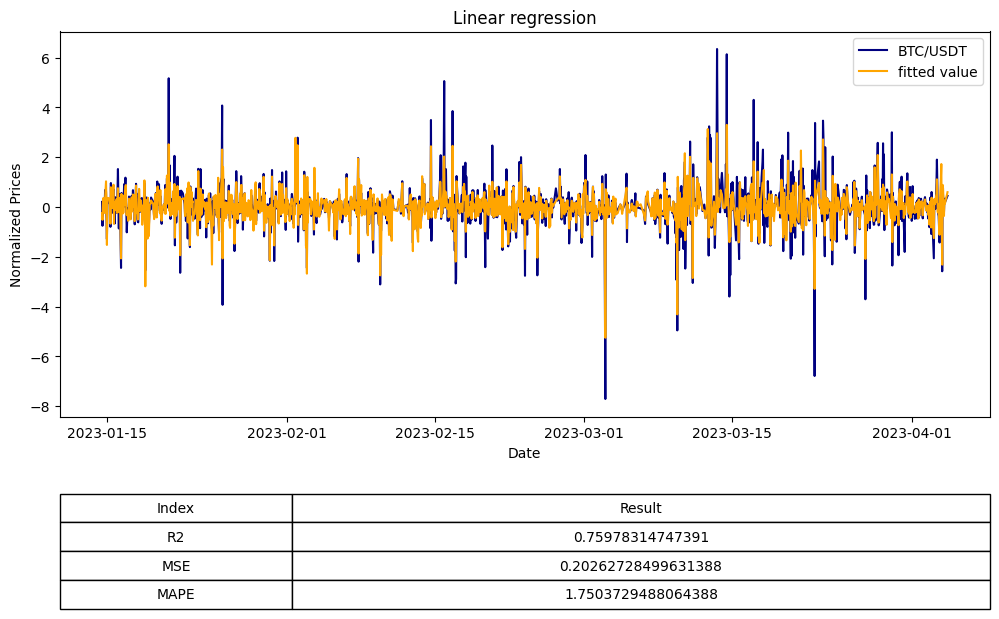

Task Complete. 


In [14]:
linreg_model = LinearRegression(fit_intercept=False)

linreg_model.fit(train_df[predictor_cols], train_df[target_col])
test_df["linreg_predicted_rate_of_return"] = linreg_model.predict(test_df[predictor_cols])
linreg_mse = MSE(test_df["linreg_predicted_rate_of_return"],test_df[target_col])
print("Learned coefficients:",linreg_model.coef_)

generate_result("Linear regression", test_df[target_col], test_df["linreg_predicted_rate_of_return"], test_df.index)

## Ridge Regression

Learned coefficients: [0.02508905 0.03252751 0.64843661 0.01086524 0.0919059  0.04026382
 0.09268339]


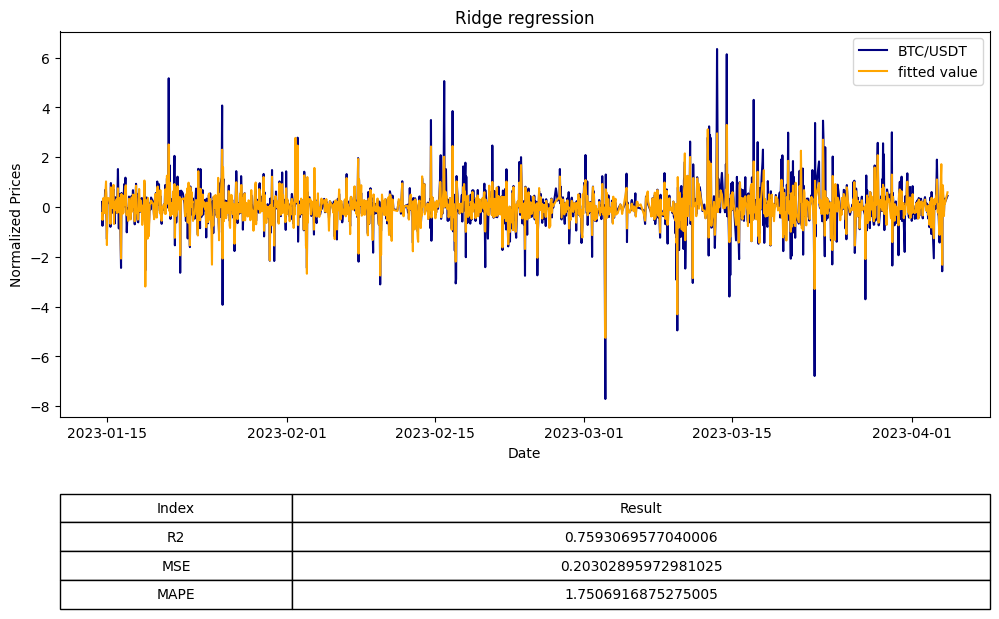

Task Complete. 


In [15]:
# Train and evaluate the ridge regression model with cross-validation
alpha_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge_model = Ridge(fit_intercept=False)
ridge_cv_model = GridSearchCV(estimator=ridge_model, param_grid={'alpha': alpha_range}, cv=5)
ridge_cv_model.fit(train_df[predictor_cols], train_df[target_col])
best_alpha = ridge_cv_model.best_params_['alpha']
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(train_df[predictor_cols], train_df[target_col])
test_df["ridge_predicted_rate_of_return"] = ridge_model.predict(test_df[predictor_cols])
ridge_mse = MSE(test_df["ridge_predicted_rate_of_return"], test_df[target_col])
print("Learned coefficients:",ridge_model.coef_)

generate_result("Ridge regression", test_df[target_col], test_df["ridge_predicted_rate_of_return"], test_df.index)

## Lasso Regression

Learned coefficients: [0.0248016  0.03205485 0.6517142  0.00999421 0.09147522 0.03983221
 0.09199711]


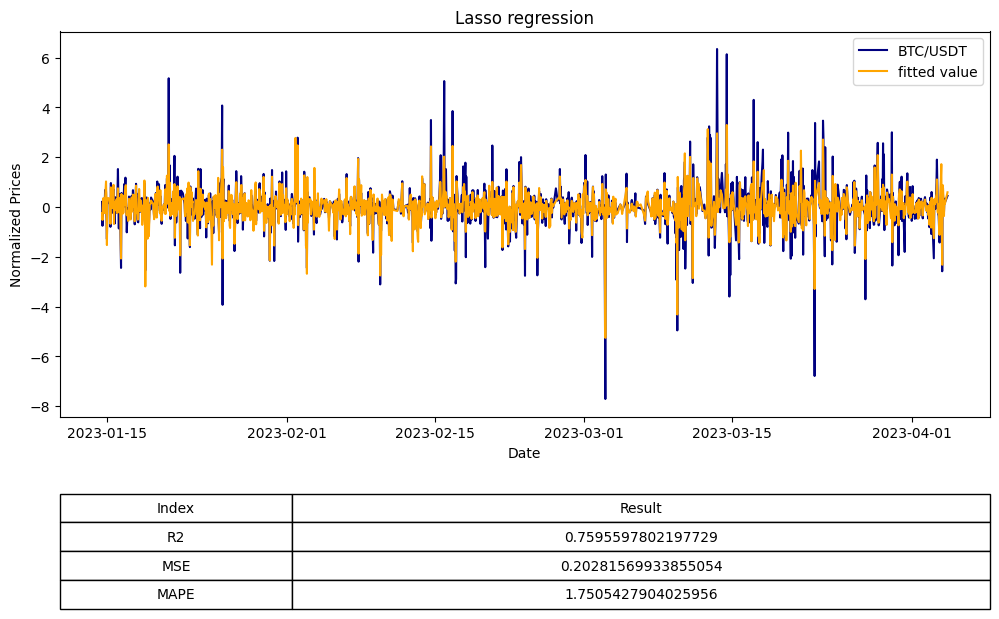

Task Complete. 


In [16]:
# Train and evaluate the ridge regression model with cross-validation
alpha_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lasso_model = Lasso(fit_intercept=False)
lasso_cv_model = GridSearchCV(estimator=lasso_model, param_grid={'alpha': alpha_range}, cv=5)
lasso_cv_model.fit(train_df[predictor_cols], train_df[target_col])
best_alpha = lasso_cv_model.best_params_['alpha']
lasso_model = Ridge(alpha=best_alpha)
lasso_model.fit(train_df[predictor_cols], train_df[target_col])
test_df["lasso_predicted_rate_of_return"] = lasso_model.predict(test_df[predictor_cols])
lasso_mse = MSE(test_df["lasso_predicted_rate_of_return"], test_df[target_col])
print("Learned coefficients:",lasso_model.coef_)

generate_result("Lasso regression", test_df[target_col], test_df["lasso_predicted_rate_of_return"] , test_df.index)

## Elastic Net

Learned coefficients: [0.02311888 0.03007382 0.64581454 0.01035275 0.0916258  0.03979069
 0.09177517]


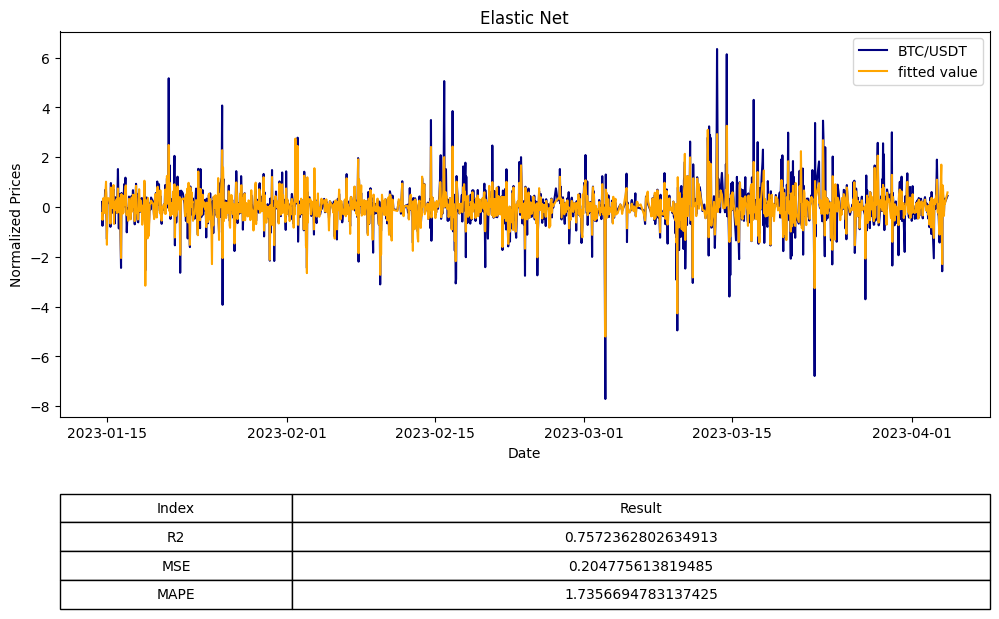

Task Complete. 


In [17]:
alpha_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
l1_ratio_range = [0.1, 0.3, 0.5, 0.7, 0.9]

# Create the Elastic Net regression model and cross-validation object
en_model = ElasticNet(fit_intercept=False)
param_grid = {'alpha': alpha_range, 'l1_ratio': l1_ratio_range}
en_cv_model = GridSearchCV(en_model, param_grid=param_grid, cv=5)

# Train the cross-validation model on the training data
en_cv_model.fit(train_df[predictor_cols], train_df[target_col])

# Get the best hyperparameter values from the cross-validation results
best_alpha = en_cv_model.best_params_['alpha']
best_l1_ratio = en_cv_model.best_params_['l1_ratio']

# Train the final Elastic Net regression model on the training data with the best hyperparameter values
en_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
en_model.fit(train_df[predictor_cols], train_df[target_col])

# Make predictions on the test data
test_df["predicted_rate_of_return"] = en_model.predict(test_df[predictor_cols])

# Evaluate the model performance on the test data
en_mse = MSE(test_df["predicted_rate_of_return"], test_df[target_col])
print("Learned coefficients:",en_model.coef_)

generate_result("Elastic Net", test_df[target_col], test_df["predicted_rate_of_return"], test_df.index)

## SVR

Learned coefficients: [0.02515759 0.02660162 0.6507571  0.00863053 0.08308182 0.01512364
 0.07951839]


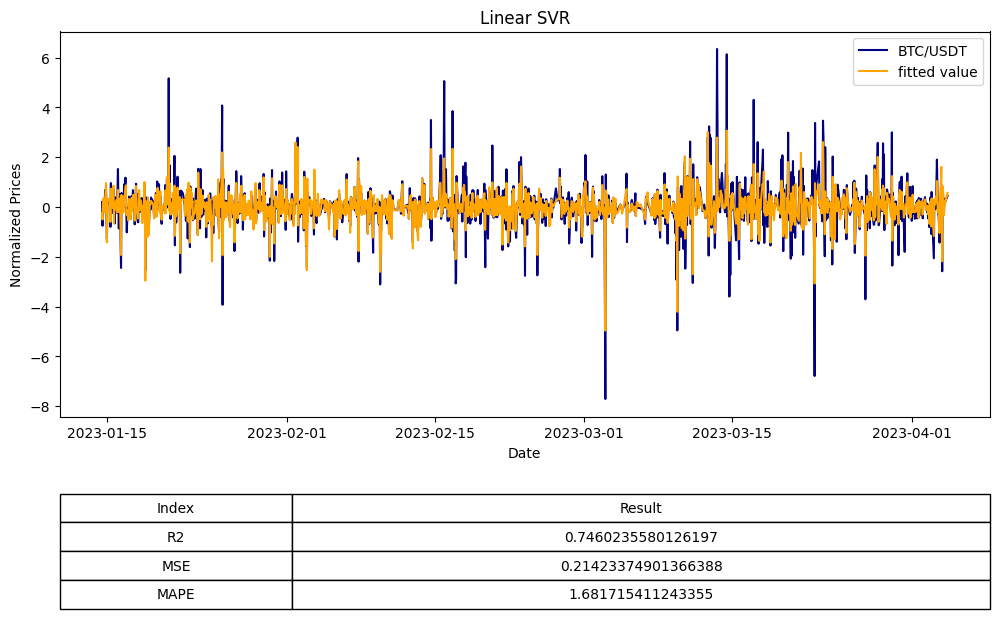

Task Complete. 


In [18]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

# Define the parameter grid to search over
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1, 10, 100]
}

# Train a linear SVR model with cross-validation and no intercept
svr_model = LinearSVR(fit_intercept=False)
svr_cv_model = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5)
svr_cv_model.fit(train_df[predictor_cols], train_df[target_col])

# Extract the best hyperparameters and train the final model
best_C = svr_cv_model.best_params_['C']
best_epsilon = svr_cv_model.best_params_['epsilon']
svr_model = LinearSVR(C=best_C, epsilon=best_epsilon, fit_intercept=False)
svr_model.fit(train_df[predictor_cols], train_df[target_col])

# Evaluate the model on the test set
test_df["svr_predicted_rate_of_return"] = svr_model.predict(test_df[predictor_cols])
svr_mse = MSE(test_df["svr_predicted_rate_of_return"], test_df[target_col])
print("Learned coefficients:",svr_model.coef_)

# Generate the evaluation report
generate_result("Linear SVR", test_df[target_col], test_df["svr_predicted_rate_of_return"], test_df.index)


## SGD Regression

Learned coefficients: [0.01456359 0.02763204 0.64556801 0.00796128 0.08977548 0.03496037
 0.0877281 ]


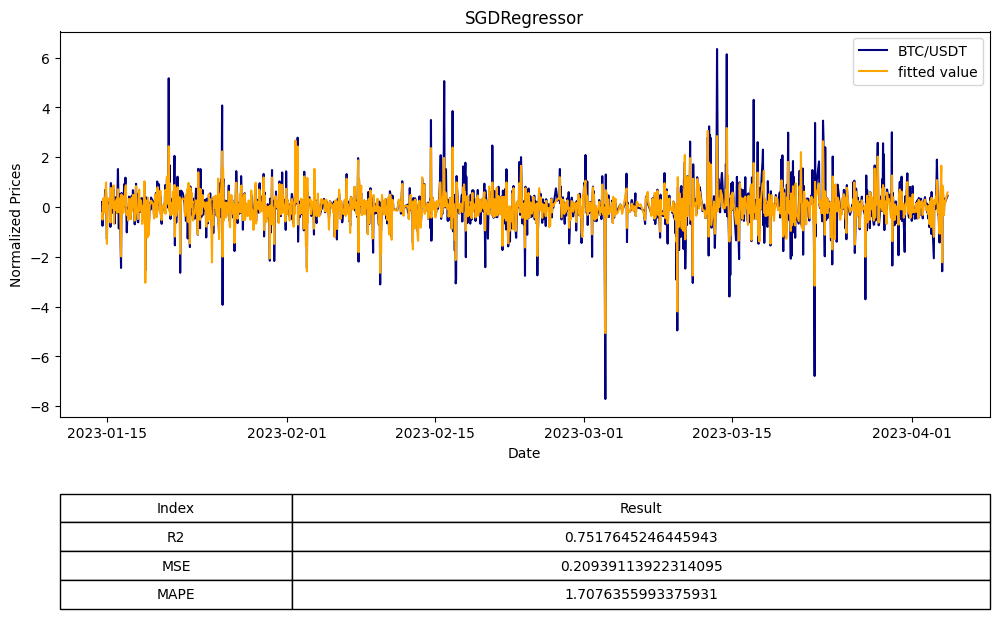

Task Complete. 


In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

# Define the parameter grid to search over
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'epsilon': [0.01, 0.1, 1, 10, 100]
}

# Train an SGDRegressor model with cross-validation and no intercept
sgd_model = SGDRegressor(fit_intercept=False)
sgd_cv_model = GridSearchCV(estimator=sgd_model, param_grid=param_grid, cv=5)
sgd_cv_model.fit(train_df[predictor_cols], train_df[target_col])

# Extract the best hyperparameters and train the final model
best_alpha = sgd_cv_model.best_params_['alpha']
best_epsilon = sgd_cv_model.best_params_['epsilon']
sgd_model = SGDRegressor(alpha=best_alpha, epsilon=best_epsilon, fit_intercept=False)
sgd_model.fit(train_df[predictor_cols], train_df[target_col])

# Evaluate the model on the test set
test_df["sgd_predicted_rate_of_return"] = sgd_model.predict(test_df[predictor_cols])
sgd_mse = MSE(test_df["sgd_predicted_rate_of_return"], test_df[target_col])
print("Learned coefficients:", sgd_model.coef_)

# Generate the evaluation report
generate_result("SGDRegressor", test_df[target_col], test_df["sgd_predicted_rate_of_return"], test_df.index)


## Best Subsets Selection

Optimal set of predictor variables: ['XLM_USDT_ror', 'DOGE_USDT_ror', 'ETH_USDT_ror', 'LINK_USDT_ror', 'DOT_USDT_ror', 'ADA_USDT_ror', 'SOL_USDT_ror']
Best Subsets Linear Regression mean squared error: 0.20262728499631388
Learned coefficients: [0.02482306 0.03205    0.65172687 0.00998766 0.09146109 0.03985189
 0.09198309]


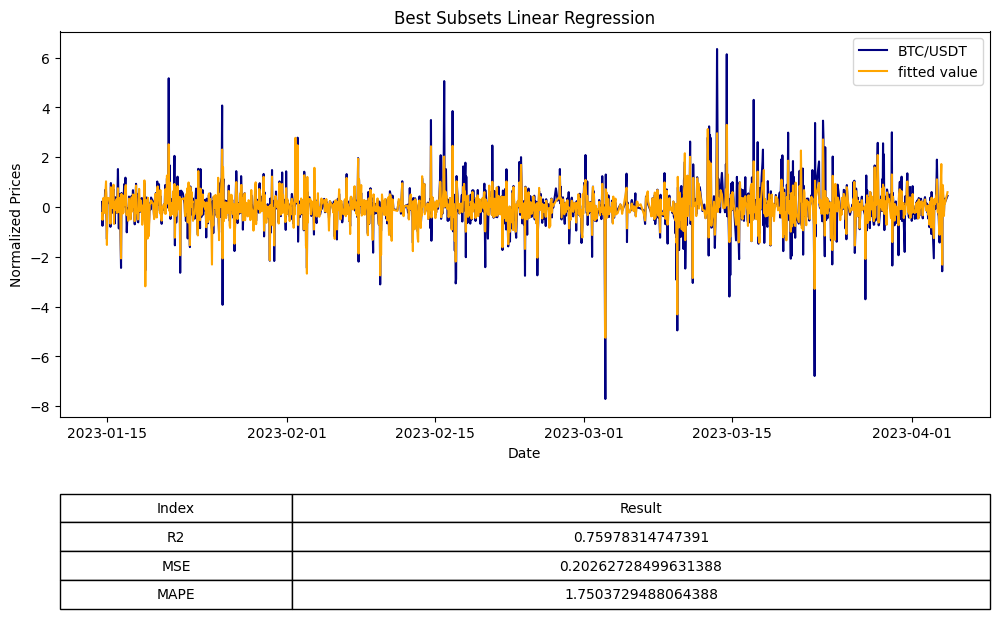

Task Complete. 


In [20]:
def best_subset_selection(X, y):
    """
    Implements best subset selection for feature selection
    
    Parameters:
    X (numpy array): Input features
    y (numpy array): Target variable
    
    Returns:
    best_features (list): List of the best features
    """
    
    # Get the number of features
    num_features = X.shape[1]
    
    # Initialize the best score and feature list
    best_score = -np.inf
    best_features = []
    
    # Loop over all possible feature combinations
    for k in range(1, num_features+1):
        for subset in itertools.combinations(range(num_features), k):
            # Train a linear regression model using the current feature subset
            model = LinearRegression().fit(X[:, subset], y)
            score = model.score(X[:, subset], y)
            
            # Update the best score and feature list if necessary
            if score > best_score:
                best_score = score
                best_features = list(subset)
                
    return best_features

optimal_predictor_cols = best_subset_selection(train_df[predictor_cols].values, train_df[target_col].values)
print("Optimal set of predictor variables:", [predictor_cols[i] for i in optimal_predictor_cols])

# Train a linear regression model using the optimal set of predictor variables
B_linreg_model = LinearRegression(fit_intercept=False)
B_linreg_model.fit(train_df[predictor_cols].iloc[:, optimal_predictor_cols], train_df[target_col])

# Make predictions on the test set using the trained model
test_df["best_linreg_predicted_rate_of_return"] = B_linreg_model.predict(test_df[predictor_cols].iloc[:, optimal_predictor_cols])

# Compute the mean squared error of the predictions
B_linreg_mse = MSE(test_df["best_linreg_predicted_rate_of_return"], test_df[target_col])
print("Best Subsets Linear Regression mean squared error:", B_linreg_mse)
print("Learned coefficients:", B_linreg_model.coef_)
generate_result("Best Subsets Linear Regression", test_df[target_col], test_df["best_linreg_predicted_rate_of_return"], test_df.index)


<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>